# Информация по тестовому заданию

## Вводная часть

В Контуре мы много работаем с документами: арбитражные иски, госзакупки, исполнительные производства. В данном задании мы предлагаем вам сделать модель, которая поможет отделу госзакупок извлекать 
нужный кусок текста из документа для того, чтобы сформировать анкету заявки. То, какой именно фрагмент текста нужно извлечь, зависит от пункта анкеты, соответствующего документу.
Всего в каждом документе, с которыми вы будет работать, есть 1 из 2-х пунктов анкеты, по которым необходимо извлекать кусочки из текста:
- обеспечение исполнения контракта
- обеспечение гарантийных обязательств

Соответственно, ваша модель, принимая на вход `текст документа` и `наименование одного из двух пунктов`, должна возвращать `соответствующий кусочек текста из текста документа`.

## Данные

### train.json

Данные для обучения в формате json имеют следующие поля:
- `id`: int - id документа
-  `text`: str - текст документа, в котором может содержаться фрагмент текста, соответствующий пункту анкеты из поля `label`
- `label`: str - название пункта анкеты. Может принимать одно из двух значений: `обеспечение исполнения контракта` или `обеспечение гарантийных обязательств`
- `extracted_part`: dict следующего формата:
    ```
    {
        'text': [фрагмент текста из поля `text`, соответствующий пункту анкеты], 
        'answer_start': [индекс символа начала фрагмента текста в тексте документа],
        'answer_end': [индекс символа конца фрагмента текста в тексте документа]
    }
   ```

### test.json

Для демонстрации работы модели используйте данные из файла `test.json`. В нем есть все те же поля, что и в файле `train.json`, кроме поля `extracted_part` - именно его вам и нужно будет добавить,
для того, чтобы мы смогли оценить качество вашей модели.

## Тестовое задание

Для выполнения тестового задания требуется разработать модель, которая будет способна по паре `текст документа` и `пункт анкеты` извлекать из текста документа нужный фрагмент текста. 
Обучив модель, добавьте в файл `test.json` поле `extracted_part` в том же формате, что и в файле `train.json`. Новый файл назовите `predictions.json`

**Подсказка**: изучив данные, вы можете заметить, что у части наблюдений отсутствует фрагмент текста к извлечению (пустая строка внутри поля `extracted_part` с `answer_start` и
`answer_end` равными нулю). Это означает, что в тексте документа нет нужного фрагмента текста, соответствующего пункту анкеты. Учтите это в обучении вашей модели и при формировании
файла с ответами.

## Критерии оценки


1. Для оценки финального решения будет использоваться метрика `Accuracy`: доля наблюдений, в которых извлеченный моделью фрагмент текста полностью соответствует фактически
   требуемому фрагменту.
2. Чистота кода, оформление и понятность исследования.

## Требования к решению

В качестве решения мы ожидаем zip-архив со всеми *.py и *.ipynb файлами в папке solution и файлом `predictions.json` в корне. Формат имени zip-архива: LastName_FirstName.zip (пример Ivanov_Ivan.zip).
Файл `predictions.json` должен включать в себя колонки `id`, `text`, `label`, содержащие те же данные, что и исходный файл `test.json`, а также колонку `extracted_part` в том же
формате, что и в файле `train.json`
Разметка тестового набора данных и включение его в обучение/валидацию запрещены.

В папке solution должно быть отражено исследование и весь код, необходимый для воспроизведения исследования.

Успехов!

# Решение задачи

## Загрузка и анализ данных

In [1]:
# Подключение к гугл диску для быстрой загрузки данных и сохранения результатов


from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [23]:
# Импортируем необходимые библиотеки


# Для работы с файлами/данными
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Для отслеживания прогресса
from tqdm import tqdm

# Для создания Ner модели
import spacy
from spacy.tokens import DocBin
import spacy_transformers

# Для визуализации данных
import matplotlib.pyplot as plt


In [ ]:
# Если у вас не установлена библиотека spaCy и нужные компоненты, то выполните установочные команды ниже
# При возникновении ошибок по установке библиотек смотрите документацию с сайта (https://spacy.io/usage)

'''
!pip install -U pip setuptools wheel
!pip install -U 'spacy[transformers,lookups]'
!python -m spacy download ru_core_news_lg
'''

In [193]:
# Напишем функции для удобной загрузки и записи данных


def load_data(file):
    with open (file, 'r', encoding='UTF-8') as f:
        data = json.load(f)
    return (data)


def write_data(file, data):
    with open (file, 'w', encoding='UTF-8') as f:
        json.dump(data, f, indent=4, ensure_ascii=False)

        
data_train = load_data('/content/gdrive/MyDrive/Colab Notebooks/Тестовые задания/Итоговая версия/train.json')
data_test = load_data('/content/gdrive/MyDrive/Colab Notebooks/Тестовые задания/Итоговая версия/test.json')

In [4]:
# Посмотрим на структуру данных на примере

data_train[21]

{'id': 661965202,
 'text': 'Извещение о проведении электронного аукциона для закупки №0142100004722000020 Общая информация Номер извещения 0142100004722000020 Наименование объекта закупки Приобретение и обновление лицензий ПО в сфере информационной безопасности Способ определения поставщика (подрядчика, исполнителя) программное обеспечение 58.29.50.000 Условная единица 1 447010.00 447010.00 Итого: 447010.00 Российский рубль Преимущества и требования к участникам Преимущества Преимущество в соответствии с ч. 3 ст. 30 Закона № 44-ФЗ Требования к участникам 1 Единые требования к участникам закупок в соответствии с ч. 1 ст. 31 Закона № 44-ФЗ 2 Требования к участникам закупок в соответствии с ч. 1.1 ст. 31 Закона № 44-ФЗ Ограничения Не установлены Обеспечение заявки Требуется обеспечение заявки Размер обеспечения заявки 4470.10 Российский рубль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Согласно аукционной документации Рекв

In [5]:
# Оценим баланс классов и количество пропусков (отсутствие информации) в каждом классе


count_labels = {'Количество меток "обеспечение исполнения контракта"': 0, 
                'Количество меток "обеспечение гарантийных обязательств"': 0}

count_skip = {'Количество пропусков в метке "обеспечение исполнения контракта"': 0, 
              'Количество пропусков в метке "обеспечение гарантийных обязательств"': 0}

for i in data_train:
    if i['label'] == 'обеспечение исполнения контракта':
        if i['extracted_part']['text'][0] != '':
            count_labels['Количество меток "обеспечение исполнения контракта"'] +=1
        else:
            count_skip['Количество пропусков в метке "обеспечение исполнения контракта"'] +=1
    
    if i['label'] == 'обеспечение гарантийных обязательств':
        if i['extracted_part']['text'][0] != '':
            count_labels['Количество меток "обеспечение гарантийных обязательств"'] +=1
        else:
            count_skip['Количество пропусков в метке "обеспечение гарантийных обязательств"'] +=1
        
        
count_labels, count_skip

({'Количество меток "обеспечение исполнения контракта"': 984,
  'Количество меток "обеспечение гарантийных обязательств"': 508},
 {'Количество пропусков в метке "обеспечение исполнения контракта"': 4,
  'Количество пропусков в метке "обеспечение гарантийных обязательств"': 303})

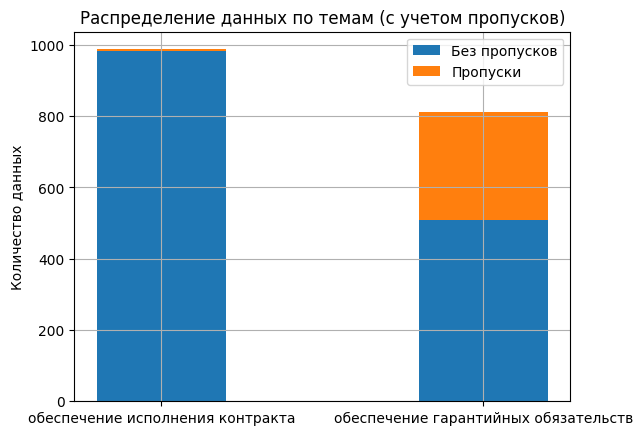

In [6]:
# Визуализируем полученные выше данные


labels = ['обеспечение исполнения контракта', 'обеспечение гарантийных обязательств']
list_count_labals = list(count_labels.values())
list_count_skip = list(count_skip.values())

bar_labels = plt.bar ([0, 1], list_count_labals, width=0.4)
bar_skip = plt.bar ([0, 1], list_count_skip, bottom=list_count_labals, width=0.4)

plt.ylabel('Количество данных')
plt.title('Распределение данных по темам (с учетом пропусков)')
plt.xticks ([0, 1], labels)
plt.legend((bar_labels[0], bar_skip[0]),('Без пропусков', 'Пропуски'))
plt.grid()

plt.show()

**Вывод по имеющимся данным для обучения:** пропусков для метки '*обеспечение гарантийных обязательств*' довольно много. Но как было сказано в описание задания, такие данные возможны (в данных текстах просто нет нужной информации для извлечения). 

Больше всего тревожит дисбаланс классов, т.к., по хорошему, они должны быть +- одинаковыми, а у нас они отличаются почти в 2 раза. Данных не так много, чтобы просто удалить часть до их равенства.

На данный момент, мы оставим все как есть и просто удалим данные без нужной информации (пропуски).

## Подготовка данных для обучения

Для нашей задачи по извлечению нужной информации (именованных сущностей) из текста будем обучать 2 вида NER модели, с помощью библиотеки spaCy 3:
- 1 модель построена на pipeline = ["tok2vec","ner"]
- 2 модель-трансформер построена на pipeline = ["transformer","ner"]

In [7]:
# Для обучения NER модели нам нужно пересобрать наши данные в нужном формате и без лишних данных


def prepare_data(data):
    prepared_data = []
    for record in data:
        text = record['text']

        start = record['extracted_part']['answer_start'][0]
        end = record['extracted_part']['answer_end'][0]
        label = record['label']

        ents = {"entities": [(start, end, label)]}
        
        prepared_data.append((text, ents))
    return (prepared_data)

data_train_prepared = prepare_data(data_train)

In [8]:
data_train_prepared[0]

('Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты счета в соответствии с п.16 ч. 

In [10]:
# Избавимся от пропусков (данных, без нужной информации для извлечения)


data_train_cleaned = []

for comment in data_train_prepared:
    if comment[1]['entities'][0][0] != 0:
        data_train_cleaned.append(comment)
        
len(data_train_cleaned)

1492

In [13]:
# Разделим очищенные данные на тренировочные и проверочные


train_data, val_data = train_test_split(data_train_cleaned, test_size=0.2, random_state=21)

print(len(train_data), len(val_data))

1193 299


In [15]:
# Для последующей корректной работы кода, уже должны быть установлены


'''
!pip install -U 'spacy[transformers,lookups]'
!python -m spacy download ru_core_news_lg
'''


# В среде Colab есть вероятность столкнуться с ошибкой кодировки (ниже код для исправления этой ошибки)

import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [17]:
# Преобразуем наши подготовленные данные в doc формат для обучения с помощью spaCy 3


def convert_data(data, out_name='train.spacy'):
    nlp = spacy.load('ru_core_news_lg') # загрузим языковую модель

    db = DocBin() # создадим DocBin объект

    for text, annot in tqdm(data): # преобразуем в цикле наши данные
        doc = nlp.make_doc(text) 
        ents = []
        for start, end, label in annot['entities']: 
            span = doc.char_span(start, end, label=label, alignment_mode='contract')
            ents.append(span)
        doc.ents = ents
        db.add(doc)

    db.to_disk(out_name) # сохраняем в среду colab

convert_data(train_data), convert_data(val_data, 'val.spacy')

100%|██████████| 299/299 [00:01<00:00, 200.37it/s]


(None, None)

## Обучение моделей

### Модель 1: pipeline = ["tok2vec","ner"]

In [18]:
# Следующим этапом создаем конфигурационный файл для обучения
# Базовый файл можно сформировать по ссылке с оффициального сайта: https://spacy.io/usage/training


!python -m spacy init fill-config '/content/gdrive/MyDrive/Colab Notebooks/Тестовые задания/Итоговая версия/base_config_cpu.cfg' config_cpu.cfg

# После получения базового конфигурационного файла (будет сохранен в среду colab), 
# в строке vectors указываем стартовые данные "ru_core_news_lg" для обучения. 

2023-04-23 08:54:24.563574: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
✔ Auto-filled config with all values
✔ Saved config
config_cpu.cfg
You can now add your data and train your pipeline:
python -m spacy train config_cpu.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [ ]:
# Запускаем процесс обучения 1 модели NER (лучшую и последнюю модель сохраняем на гугл диск)


!python -m spacy train config_cpu.cfg --output '/content/gdrive/MyDrive/Colab Notebooks/Тестовые задания/Итоговая версия/output_cpu' --paths.train ./train.spacy --paths.dev ./val.spacy 

✔ Created output directory: output
ℹ Saving to output directory: output
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2023-04-21 22:01:32,499] [INFO] Set up nlp object from config
[2023-04-21 22:01:32,511] [INFO] Pipeline: ['tok2vec', 'ner']
[2023-04-21 22:01:32,515] [INFO] Created vocabulary
[2023-04-21 22:01:35,413] [INFO] Added vectors: ru_core_news_lg
[2023-04-21 22:01:37,632] [INFO] Finished initializing nlp object
[2023-04-21 22:01:51,173] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00    192.60    0.00    0.00    0.00    0.00
  0     200       3191.00   6932.93    0.00    0.00    0.00    0.00
  0     400 

### Модель 2: pipeline = ["transformer","ner"]

In [21]:
# Аналогичным действием создаем конфигурационный файл для обучения, но уже для модели transformer
# Базовый файл можно сформировать по ссылке с оффициального сайта: https://spacy.io/usage/training


!python -m spacy init fill-config '/content/gdrive/MyDrive/Colab Notebooks/Тестовые задания/Итоговая версия/base_config_gpu.cfg' config_gpu.cfg

# После получения базового конфигурационного файла (будет сохранен в среду colab), 
# в строке vectors указываем стартовые данные "ru_core_news_lg" для обучения. 

2023-04-23 09:29:55.486886: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
✔ Auto-filled config with all values
✔ Saved config
config_gpu.cfg
You can now add your data and train your pipeline:
python -m spacy train config_gpu.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [ ]:
# Запускаем процесс обучения 2 модели NER (лучшую и последнюю модель сохраняем на гугл диск)
# В данном случае, это модель BERT, которую рекомендуется обучать на GPU


!python -m spacy train -g 0 config_gpu.cfg --output '/content/gdrive/MyDrive/Colab Notebooks/Тестовые задания/Итоговая версия/output_gpu/model-best' --paths.train ./train.spacy --paths.dev ./val.spacy 

2023-04-22 05:49:03.290304: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
✔ Created output directory: /content/gdrive/MyDrive/Colab
Notebooks/Тестовые задания/output
ℹ Saving to output directory: /content/gdrive/MyDrive/Colab
Notebooks/Тестовые задания/output
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2023-04-22 05:49:14,680] [INFO] Set up nlp object from config
[2023-04-22 05:49:14,695] [INFO] Pipeline: ['transformer', 'ner']
[2023-04-22 05:49:14,700] [INFO] Created vocabulary
[2023-04-22 05:49:18,286] [INFO] Added vectors: ru_core_news_lg
[2023-04-22 05:49:21,296] [INFO] Finished initializing nlp object
Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.p

К сожалению, до конца обучить модель не получилось, ввиду ограничений по памяти у Colab. Поэтому имеем только тот результат, который успели получить. Возможно модель смогла бы и улучшить Score. 

**Вывод:** ожидаемо, трансформер-модель показывает лучшую точность распознования именованных сущностей (нужной информации), поэтому для предсказания будем сначала использовать ее, а если она не сможет распознать, то уже попробуем через RNN модель (модель 1). 

## Загрузка лучших моделей

### Модель 1

In [19]:
# Загружаем лучшую модель 1


ner_model_1 = spacy.load(r'/content/gdrive/MyDrive/Colab Notebooks/Тестовые задания/Итоговая версия/output_cpu/model-best')

In [72]:
# Проверим работоспособность модели, предсказав один из результатов для тестовых данных (их модель еще не видела)

doc = ner_model_1(data_test[1]['text'])
spacy.displacy.render(doc, style="ent", jupyter=True) # Для визуального отображения предсказанной информации

### Модель 2

In [24]:
# Загружаем лучшую модель 2


ner_model_2 = spacy.load(r'/content/gdrive/MyDrive/Colab Notebooks/Тестовые задания/Итоговая версия/output_gpu/model-best')

In [71]:
# Проверим работоспособность модели, предсказав один из результатов для тестовых данных (их модель еще не видела)


doc = ner_model_2(data_test[1]['text'])
spacy.displacy.render(doc, style="ent", jupyter=True) # Для визуального отображения предсказанной информации

## Небольшой анализ результатов работ моделей

Сделаем небольшой сравнительный анализ работы 2-х моделей на тестовых данных. Пусть это и довольно грубый вариант, но зато он может ответить на интересующие вопросы:
- Количество совпадений извлеченных ответов у 2-х моделей
- Количество пропусков (нет нужной информации) у каждой модели
- Количество раз, когда одна модель имеет какую-то информацию, а другая нет

Все это позволит немного оценить, насколько хорошо модели извлекают информацию. 

In [74]:
# Посмотрим, насколько хорошо или плохо справляются с тестовыми данными каждая из моделей


count_try = 0
count_false = 0
count_try_idx = []
count_false_idx = []


count_none_m1 = 0
count_none_m2 = 0
count_none_m1_idx = []
count_none_m2_idx = []

count_know_m1_without_m2 = 0
count_know_m2_without_m1 = 0
count_know_m1_without_m2_idx = []
count_know_m2_without_m1_idx = []

for idx, text in tqdm(enumerate(data_test)):
  doc_1 = ner_model_1(text['text'])
  doc_2 = ner_model_2(text['text'])
  if doc_1.ents != () and doc_2.ents != ():
    if str(doc_1.ents[0]) == str(doc_2.ents[0]):
      count_try += 1
      count_try_idx.append(idx)

    if str(doc_1.ents[0]) != str(doc_2.ents[0]):
      count_false += 1
      count_false_idx.append(idx)

  elif doc_1.ents == ():
    count_none_m1 += 1
    count_none_m1_idx.append(idx)
  elif doc_2.ents == ():
    count_none_m2 += 1
    count_none_m2_idx.append(idx)

  if doc_1.ents != () and doc_2.ents == ():
    count_know_m1_without_m2 += 1
    count_know_m1_without_m2_idx.append(idx)
  if doc_1.ents == () and doc_2.ents != ():
    count_know_m2_without_m1 += 1
    count_know_m2_without_m1_idx.append(idx)


print('\nКоличество совпадений ответов у моделей:', count_try)
print('Количество не совпадений ответов у моделей:', count_false)

print('Количество пропусков у 1 модели:', count_none_m1)
print('Количество пропусков у 2 модели:', count_none_m2)

print('Есть информация у 1 модели, а у 2 нет:', count_know_m1_without_m2)
print('Есть информация у 2 модели, а у 1 нет:', count_know_m2_without_m1)


318it [23:21,  4.41s/it]


Количество совпадений ответов у моделей: 148
Количество не совпадений ответов у моделей: 68
Количество пропусков у 1 модели: 98
Количество пропусков у 2 модели: 4
Есть информация у 1 модели, а у 2 нет: 4
Есть информация у 2 модели, а у 1 нет: 38


Оценивая результаты, хочется особенно взглянуть на данные, где модель-трансформер не справилась, а RNN модель что-то извлекла из текста. 

In [77]:
count_know_m1_without_m2_idx

[15, 141, 178, 305]

In [76]:
# Посмотрим на эти примеры


for idx in count_know_m1_without_m2_idx:
  doc_1 = ner_model_1(data_test[idx]['text'])
  spacy.displacy.render(doc_1, style="ent", jupyter=True)

Резюмируя просмотренные данные, можно сделать вывод, что модель хорошо предсказала для data_test[15] (не сосем полно, но суть передает хорошо), а вот с остальными данными сложнее. Для data_test[141] и data_test[178] нужно разбираться в контексте данных, чтобы понять, что действительно важно. А в data_test[305] вообще не правильное выделение. Там, скорее всего, пропуск. 

Учитывая, что ни один из примеров не является полностью правильным, на мой взгляд (а в критериях оценки написано, что извлеченный фрагмент должен **полностью** соответствовать выделенному фрагменту), то я просто вынужден пропустить эти примеры. Хотя первый пример очень близок к правильной разметке, я так думаю. 

# Формирование тестового файла с предсказаниями информации

Учитывая небольшой сравнитальный анализ выше, в итоговые варианты ответов будем включать только информацию, извлеченную 2 моделью (трансформер)

In [163]:
# Еще раз посмотрим на требуемыю структуру данных для ответов, на примере тренировочного файла


data_train[:2]

[{'id': 809436509,
  'text': 'Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты сче

In [164]:
data_test[:2]

[{'id': 762883279,
  'text': 'МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание услуг по техническому обслуживанию и ремонту принтеров и многофункциональных устройств, заправке и восстановлению картриджей (идентификационный код закупки 223861800296886010100100590019511244) г. Ханты-Мансийск «___» ____________ 2022 г.  (или) возмещения убытков причинённых Исполнителем убытков. 6. Обеспечение исполнения контракта 6.1. Исполнение контракта обеспечиваются предоставлением независимой гарантии, выданной банком и соответствующей требованиям Федерального закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд», или внесением денежных средств на указанный заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими заказчику. Способ обеспечения исполнения контракта, срок действия независимой гарантии определяются в соответствии с требованиями Ф

In [183]:
# Напишем функцию для получения ответов от модели 2 (Ner-transformer)


def NER_transformer_for_text (text, label):
  doc = ner_model_2(text) # Получение предсказаний модели

  if len(doc.ents) > 1: # Если, модель предлагает 2 и более ответа, то избавляемся путем перепроверки самой моделью
    for ent in doc.ents: # Берем первый предложенный вариант и перепроверяем
      try_text = ent.text # Получили текст предсказания
      start = ent.start_char # Получили стартовый индекс
      end = ent.end_char # Получили конечный индекс
      try_label = ent.label_ # Получили метку класса

      doc_repeat = ner_model_2(text[start:end]) # Перепроверям предсказания, передав только саму строчку с предсказанием
      
      if doc_repeat != (): # Если предсказания не обнулились, то значит вывод был предсказан верно и он повторился
        if label == try_label: # Проверяем метку класса
          return {'text': [try_text], 'answer_start': [start],'answer_end': [end]}
      else: # Если предсказания не повторились, значит берем следующий элемент из цикла
        continue 
  elif len(doc.ents) == 0: # когда в тексте нет нужной информации
    return {'text': [''], 'answer_start': [0],'answer_end': [0]}
  else: # выполняется, когда предсказанный элемент всего 1
    for ent in doc.ents:
      try_text = ent.text
      start = ent.start_char
      end = ent.end_char
      try_label = ent.label_
    if label == try_label:
      return {'text': [try_text], 'answer_start': [start],'answer_end': [end]}

In [186]:
# Проверим работоспособность функции


NER_transformer_for_text(data_test[0]['text'], 'обеспечение исполнения контракта')

{'text': ['Размер обеспечения исполнения Контракта составляет _______ рублей ____ копеек (5 процентов от цены контракта).'],
 'answer_start': [1283],
 'answer_end': [1393]}

In [154]:
NER_transformer_for_text(data_test[206]['text'], 'обеспечение гарантийных обязательств')

{'text': ['Обеспечение гарантийных обязательств установлено в размере 1 % начальной (максимальной) цены контракта, что составляет: 266 577,10 руб*.'],
 'answer_start': [1297],
 'answer_end': [1433]}

In [187]:
# Создадим итоговый файл


predictions = []

for comment in tqdm(data_test):
  comment['extracted_part'] = NER_transformer_for_text(comment['text'], comment['label'])
  predictions.append(comment)

100%|██████████| 318/318 [21:33<00:00,  4.07s/it]


In [188]:
predictions[:2]

[{'id': 762883279,
  'text': 'МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание услуг по техническому обслуживанию и ремонту принтеров и многофункциональных устройств, заправке и восстановлению картриджей (идентификационный код закупки 223861800296886010100100590019511244) г. Ханты-Мансийск «___» ____________ 2022 г.  (или) возмещения убытков причинённых Исполнителем убытков. 6. Обеспечение исполнения контракта 6.1. Исполнение контракта обеспечиваются предоставлением независимой гарантии, выданной банком и соответствующей требованиям Федерального закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд», или внесением денежных средств на указанный заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими заказчику. Способ обеспечения исполнения контракта, срок действия независимой гарантии определяются в соответствии с требованиями Ф

In [194]:
# Записываем файл в среду colab и скачиваем его


write_data('predictions.json', predictions)